In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium import FeatureGroup
from config import vworld_key
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd
from shapely import wkt
import rasterio
import base64
from matplotlib import pyplot
from rasterio.plot import show
import matplotlib.pyplot as plt

# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)

## xml 정보 위성사진에 매핑하기

In [34]:
tif_df = {
    'file_name':[],
    'file_path':[],
    'time':[],
    'imagegeogcenter':[],
    'imagegeogtl':[],
    'imagegeogtc':[],
    'imagegeogtr':[],
    'imagegeogbl':[],
    'imagegeogbc':[],
    'imagegeogbr':[],
}

# 상위 디렉토리 경로 설정
base_directory = "dataset/20.국토지리정보원_위성영상(RGB_NIR)"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
for directory in subdirectories:
    # 디렉토리 내의 XML 파일 목록 가져오기
    xml_files = [f for f in os.listdir(directory) if f.endswith("Aux.xml")]

    # 각 XML 파일을 읽어서 처리
    for xml_file in xml_files:
        xml_file_path = os.path.join(directory, xml_file)
                
        with open(xml_file_path, 'r', encoding='utf-8') as f:
            xml_doc = f.read()
        soup = bs(xml_doc, 'lxml')
        # TIFF이미지 형식 1번부터 4번까지 순회(BGRN 순)
        for img_no in range(4,5):

            # soup로 이미지 번호에 해당하는 객체 탐색
            img_lxml = soup.find("MS%s"%img_no) if soup.find("MS%s"%img_no) else soup.find("ms%s"%img_no)
            

            # 이미지 파일이름 추출 및 저장
            tif_df['file_name'].append(img_lxml.find('imagefilename').text)

            # 이미지 파일경로 저장

            tif_df['file_path'].append(directory + '/' + img_lxml.find('imagefilename').text.replace(".tif", "_geotiff.tif"))

            # UTC to yy-mm-dd 변환 및 저장
            text = img_lxml.find('utc').text.split('.')[0]
            datetime_obj = datetime.strptime(text, "%Y%m%d%H%M%S")
            tif_df['time'].append(datetime_obj.strftime("%y-%m-%d"))

            # 이미지 위치정보 저장
            img_point = ['imagegeogcenter', 'imagegeogtl', 'imagegeogtc', 'imagegeogtr', 'imagegeogbl', 'imagegeogbc', 'imagegeogbr'] # 딕셔너리 3~9 column
            lat_lst = img_lxml.find_all('latitude')
            lon_lst = img_lxml.find_all('longitude')
            for point, lat, lon in zip(img_point, lat_lst, lon_lst):
                tif_df[point].append(Point(lon, lat))

xml_metadata_df = pd.DataFrame(tif_df)
xml_metadata_df

,file_name,file_path,time,imagegeogcenter,imagegeogtl,imagegeogtc,imagegeogtr,imagegeogbl,imagegeogbc,imagegeogbr
0,C1_20230624015314_12527_00071291_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023062401...,23-06-24,POINT (126.709245 37.267593),POINT (126.615293 37.334427),POINT (126.708538 37.335088),POINT (126.801798 37.335675),POINT (126.616871 37.199436),POINT (126.70995 37.200093),POINT (126.803044 37.200678)
1,C1_20230624015314_12527_00093015_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023062401...,23-06-24,POINT (126.678512 37.370226),POINT (126.584346 37.437072),POINT (126.677775 37.437759),POINT (126.771212 37.438372),POINT (126.585986 37.302003),POINT (126.679248 37.302687),POINT (126.772517 37.303297)
2,C1_20230719015507_12907_00322813_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023071901...,23-07-19,POINT (126.869954 37.264529),POINT (126.782672 37.330089),POINT (126.869403 37.330583),POINT (126.956147 37.331014),POINT (126.783924 37.197977),POINT (126.870504 37.198468),POINT (126.957097 37.198897)
3,C1_20230808015601_13211_00650427_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023080801...,23-08-08,POINT (126.92474 37.42322),POINT (126.839744 37.488296),POINT (126.924238 37.488738),POINT (127.008745 37.489119),POINT (126.840894 37.357257),POINT (126.925241 37.357697),POINT (127.0096 37.358077)
4,C1_20230907015813_13667_00052295_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023090701...,23-09-07,POINT (126.939949 37.356858),POINT (126.856797 37.421518),POINT (126.939465 37.421939),POINT (127.022145 37.422302),POINT (126.857907 37.291348),POINT (126.940432 37.291767),POINT (127.02297 37.292128)
5,C1_20230908013931_13682_00057979_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023090801...,23-09-08,POINT (126.786612 37.349092),POINT (126.640978 37.427096),POINT (126.785864 37.42806),POINT (126.930761 37.428847),POINT (126.642776 37.269154),POINT (126.787358 37.270113),POINT (126.931952 37.270895)


### 영상 DN(Digidal Number) 값을 대기상부 복사휘도TOA Radiance(대기상부 복사휘도)로 변환

TOA 분광 복사휘도(TOA spectral radiance) = 

밴드 고유의 배수 환산계수(Band-specific multiplicative rescaling factor) * DN 값 + 밴드 고유의 가산 환산계수(Band-specific additive rescaling factor)

<img src="./pic/TSR.png" width="400" height="150">

TOA 분광 복사휘도의 단위 -> W / (m2 * sr * μm)

### TOA 분광 복사휘도를 위성사진의 밝기온도(At-satellite brightness temperature)로 재계산

K1,K2 = 밴드 고유의 열 변환 상수(Band-specific thermal conversion constant)



위성사진의 밝기온도(At-satellite bright temperature) = K2 / ln( K1 / TOA 분광 복사휘도 + 1)

<img src="./pic/ASBT.png" width="400" height="150">

배수 환산계수와 가산 환산계수는 각각 RADIANCE_MULT_BAND_{NUMBER}, RADIANCE_ADD_BAND_{NUMBER} 형식, 열 변환 상수 K1과 K2는 각각 K1_CONSTANT_BAND_{NUMBER}, K2_CONSTANT_BAND_{NUMBER}형식으로 메타데이터 내에 정의되어 있음

Landsat 8호 위성영상은 2개의 열적외 밴드(BAND_10, BAND_11)를 제공하기 때문에, 평균내어 사용할 예정

계산된 밝기온도의 단위는 절대온도(Kelvin, K)

In [71]:
# Metadata file(xml형식)에서 필요 데이터만 뽑아 데이터프레임 생성
xml_dic = {
    'image_id':[],
    'time':[],
    'coordinates':[],
    'tem_array':[],
}

# 상위 디렉토리 경로 설정
base_directory = "dataset/2.안산시_Landsat8"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
for directory in subdirectories:
    # 디렉토리 내의 Metadata XML 파일 탐색 (폴더 당 1개씩만 있기 때문에 인덱스 0으로 로드)
    xml_file = [f for f in os.listdir(directory) if f.endswith("MTL.xml")][0]

    # XML path define and read
    xml_file_path = os.path.join(directory, xml_file)
    with open(xml_file_path, 'r', encoding='utf-8') as f:
        xml_doc = f.read()

    # beautifulsoup으로 xml parsing 
    soup = bs(xml_doc, 'lxml')

    # 위성사진 id 저장
    xml_dic['image_id'].append(soup.find("landsat_product_id").text)

    # 위성사진 시간 저장(string을 datetime 객체로 변환)
    time = soup.find("date_acquired").text + ' ' + soup.find("scene_center_time").text.split(".")[0]
    xml_dic['time'].append(datetime.strptime(time, "%Y-%m-%d %H:%M:%S"))

    # 이미지 corner 위치정보 Polygon 객체로 저장
    coordinates = []
    corner_point = ['ul', 'ur', 'll', 'lr']
    for corner in corner_point:
        coordinates.append([soup.find("corner_%s_lat_product"%corner).text, soup.find("corner_%s_lon_product"%corner).text])
    xml_dic['coordinates'].append(coordinates)

    # TIF Read & 열온도 계산 및 array 형태로 저장
    BAND10 = [f for f in os.listdir(directory) if f.endswith("B10.TIF")][0]
    BAND10_path = os.path.join(directory, BAND10)
    BAND11 = [f for f in os.listdir(directory) if f.endswith("B11.TIF")][0]
    BAND11_path = os.path.join(directory, BAND11)

    # Band10과 Band11 데이터 Read
    with rasterio.open(BAND10_path) as band10_dn, rasterio.open(BAND11_path) as band11_dn:
        band10_data = band10_dn.read(1)
        band11_data = band11_dn.read(1)

    # TOA 분광 복사휘도 (TOA Spectral Radiance) 계산함수 정의 및 계산
    def cal_TSR(data, RMULT, RADD):
        TSR = (float(RMULT) * data) + float(RADD)
        return TSR
    
    RMULT10 = soup.find("radiance_mult_band_10").text
    RADD10 = soup.find("radiance_add_band_10").text
    RMULT11 = soup.find("radiance_mult_band_11").text
    RADD11 = soup.find("radiance_add_band_11").text

    BAND10_TSR = cal_TSR(band10_data, RMULT10, RADD10)
    BAND11_TSR = cal_TSR(band11_data, RMULT11, RADD11)

    # 밝기온도(At-Satellite Bright Temperature) 계산함수 정의 및 계산
    def cal_ASBT(data, K1, K2):
        ASBT = float(K2) / np.log((float(K1) / data) + 1)
        return ASBT

    K1_10 = soup.find("k1_constant_band_10").text
    K2_10 = soup.find("k2_constant_band_10").text
    K1_11 = soup.find("k1_constant_band_11").text
    K2_11 = soup.find("k2_constant_band_11").text

    BAND10_ASBT = cal_ASBT(BAND10_TSR, K1_10, K2_10)
    BAND11_ASBT = cal_ASBT(BAND11_TSR, K1_11, K2_11)

    # BAND10과 BAND11의 밝기온도 평균 계산 후, 절대온도(K) -> 섭씨온도(C) 변환하여 저장
    Mean_ASBT_K = (BAND10_ASBT + BAND11_ASBT) / 2
    Mean_ASBT_C = Mean_ASBT_K - 273.15
    xml_dic['tem_array'].append(Mean_ASBT_C)

# xml_dic 데이터프레임으로 변환
xml_df = pd.DataFrame(xml_dic)
xml_df

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


,image_id,time,coordinates,tem_array
0,LC08_L1TP_116034_20210618_20210628_02_T1,2021-06-18 02:10:54,"[[38.51209, 125.25103], [38.56742, 127.94740],...","[[-21.312143321365994, -21.347151215814677, -2..."
1,LC08_L1TP_116034_20210720_20210729_02_T1,2021-07-20 02:11:00,"[[38.51038, 125.28208], [38.56499, 127.97843],...","[[0.18279102188762408, -0.128005103458122, -0...."
2,LC08_L1TP_116034_20210805_20210811_02_T1,2021-08-05 02:11:08,"[[38.51016, 125.27521], [38.56493, 127.97154],...","[[27.914453238950898, 28.220211004108478, 28.2..."
3,LC08_L1TP_116034_20210906_20210915_02_T1,2021-09-06 02:11:18,"[[38.51005, 125.27178], [38.56490, 127.96810],...","[[-21.698868905396665, -21.657714199015572, -2..."
4,LC08_L1TP_116034_20220605_20220610_02_T1,2022-06-05 02:11:06,"[[38.51220, 125.25447], [38.56745, 127.95084],...","[[-13.597741974474843, -13.549792282844123, -1..."
5,LC08_L1TP_116034_20220707_20220721_02_T1,2022-07-07 02:11:17,"[[38.50961, 125.25804], [38.56478, 127.95433],...","[[1.057225308862428, 0.7050034696850389, 0.344..."
6,LC08_L1TP_116034_20220824_20220923_02_T1,2022-08-24 02:11:35,"[[38.51187, 125.24417], [38.56736, 127.94051],...","[[11.548829963011656, 11.560607520578799, 11.5..."
7,LC08_L1TP_116034_20220925_20221004_02_T1,2022-09-25 02:11:42,"[[38.51154, 125.23387], [38.56727, 127.93018],...","[[4.834241154759468, 4.445163114394916, 4.2787..."



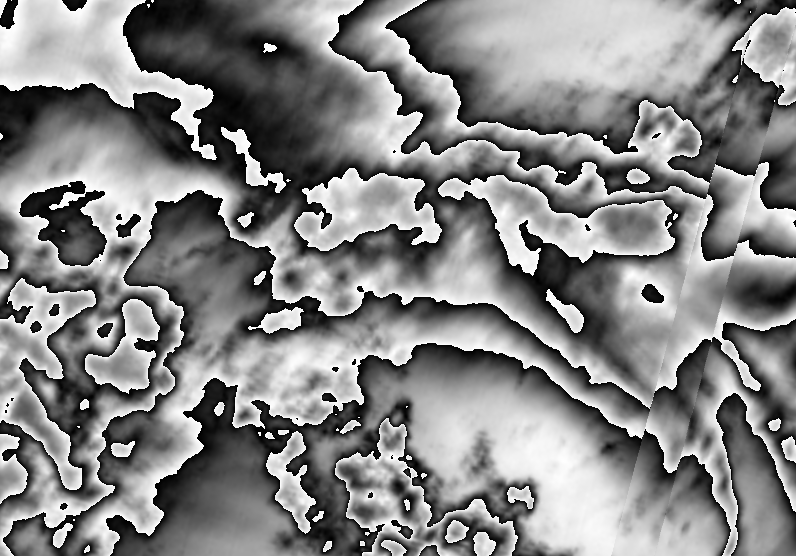

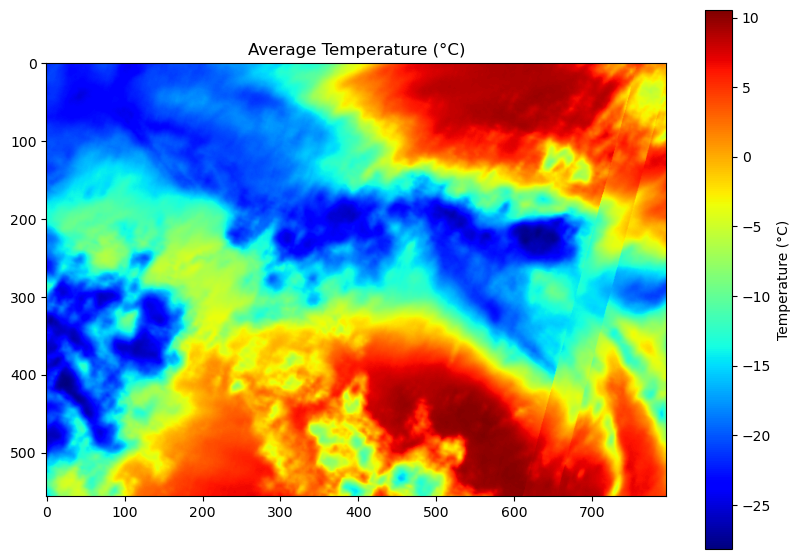

In [164]:
import folium
from rasterio.plot import show
import matplotlib.pyplot as plt
from folium import plugins
from matplotlib.colors import ListedColormap

# Folium 맵 생성
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=10)  # 지도의 중심 좌표와 줌 레벨 설정

# 일반 PNG 이미지를 Folium에 추가
folium.raster_layers.ImageOverlay(
    image=xml_df['tem_array'].tolist()[0],
    bounds=xml_df['coordinates'].tolist()[0],
    opacity=0.5,
    interactive=True,
).add_to(m)

# 컬러바를 표시하기 위해 Matplotlib 그래프 생성
plt.figure(figsize=(10, 10))
plt.title("Average Temperature (°C)")
# 데이터 플로팅
image = plt.imshow(xml_df['tem_array'].tolist()[0], cmap='jet', origin='upper')

# 컬러바 추가
colorbar = plt.colorbar(image, shrink=0.7, label="Temperature (°C)")
# Folium 지도를 출력
m

## 위성이미지 원래는 돌려서ㅏ 하는건지 확인하자

https://earthexplorer.usgs.gov/ - 로그인하고 설정해서 다운받자

https://foss4g.tistory.com/563 - Landsat 8호 위성영상에서 밝기온도 계산하기 (2)

https://ekscc.re.kr/xml/31727/31727.pdf -  정규화식생지수?

https://datasvc.nmsc.kma.go.kr/resources/common/pdf/NMSC-SCI-ATBD-LST_v1.0.pdf - 분리대기창

https://blog.si-analytics.ai/57 - 이거 좀 봐야할듯

https://scienceon.kisti.re.kr/commons/util/originalView.do?cn=JAKO201614652759836&oCn=JAKO201614652759836&dbt=JAKO&journal=NJOU00291574 - 흠 이건 논문

In [114]:
import numpy as np
from PIL import Image

# 이미지 파일을 열어 NumPy 배열로 읽기
image = Image.open("dataset/2.안산시_Landsat8/LC08_L1TP_116034_20210618_20210628_02_T1/ex/LC08_L1TP_116034_20210618_20210628_02_T1_B10.TIF")  # 이미지 파일 경로 설정
array = np.array(image)

In [124]:
geotiff_file_path = "dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624015314_12527_00071291_L2G/C1_20230624015314_12527_00071291_L2G_B.tif"

In [154]:
geotiff_file_path = "LC08_L2SP_116034_20210618_20210628_02_T1/LC08_L2SP_116034_20210618_20210628_02_T1_ST_B10.TIF"

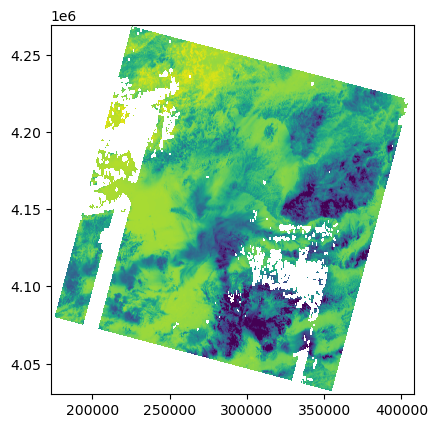

In [155]:
# GeoTIFF 파일 열기
with rasterio.open(geotiff_file_path) as src:
    # GeoTIFF 이미지를 matplotlib로 표시
    t = src.read(1)
    show(src)

In [156]:
t

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [158]:
Rad = 0.0003342 * t + 0.1

In [159]:
K = (1321.08 / np.log(774.89 / Rad + 1)) - 273.15

In [160]:
K

array([[-125.63288132, -125.63288132, -125.63288132, ..., -125.63288132,
        -125.63288132, -125.63288132],
       [-125.63288132, -125.63288132, -125.63288132, ..., -125.63288132,
        -125.63288132, -125.63288132],
       [-125.63288132, -125.63288132, -125.63288132, ..., -125.63288132,
        -125.63288132, -125.63288132],
       ...,
       [-125.63288132, -125.63288132, -125.63288132, ..., -125.63288132,
        -125.63288132, -125.63288132],
       [-125.63288132, -125.63288132, -125.63288132, ..., -125.63288132,
        -125.63288132, -125.63288132],
       [-125.63288132, -125.63288132, -125.63288132, ..., -125.63288132,
        -125.63288132, -125.63288132]])

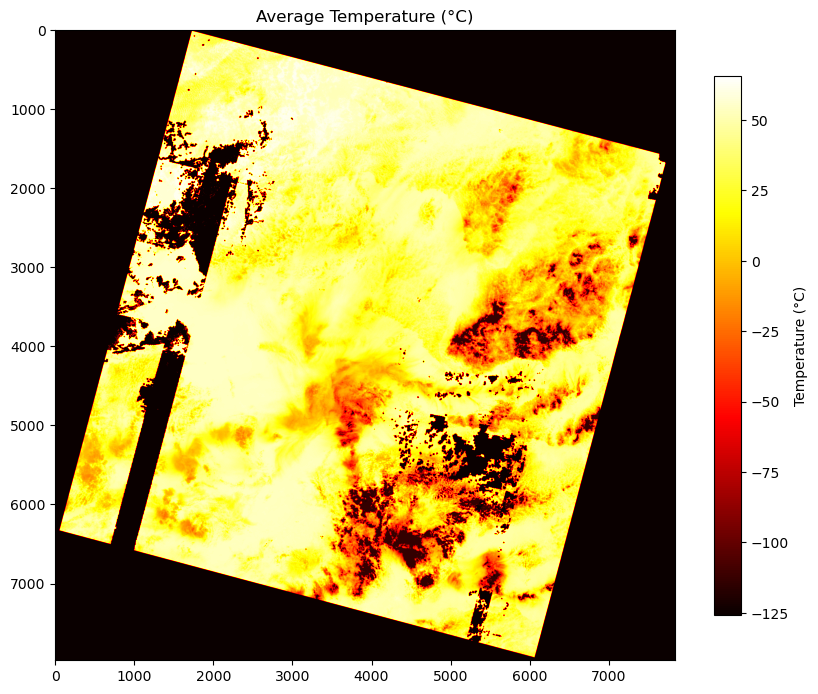

In [165]:
plt.figure(figsize=(10, 10))
plt.title("Average Temperature (°C)")
# 데이터 플로팅
image = plt.imshow(K, cmap='hot', origin='upper')

# 컬러바 추가
colorbar = plt.colorbar(image, shrink=0.7, label="Temperature (°C)")